# 12 Networks Statistics Analysis
In previous notebook, we extracted all the stats about network properties of RT networks, for each country, each period, as well as some statistics of users behaviours or account status and comparison novax community and rest of the network.
Here, we perform some simple analysis to describe networks over time, in different countries. 

In [1]:
import pandas as pd
import random
from glob import glob
from scipy.stats import ttest_ind, gaussian_kde
import numpy as np
import seaborn as sns

import matplotlib.patches as mpatches
from matplotlib.ticker import LogFormatterExponent, EngFormatter
from matplotlib.colors import LogNorm, SymLogNorm, Normalize, ListedColormap, TwoSlopeNorm
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [2]:
#stats are stored in this dataframe
info_df = pd.read_csv("/home/jlenti/Files/info_df_NoVaxCommunities_Summary_0104.csv", index_col = [0,1])

#data on edges and users are stored in this folder
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"
plots_folder = "/home/jlenti/plots/NoVax_Communities"

#list of novax communities
#i transform it into a dataframe with columns (id, country, period, community)
#novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_thres066_0402.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)
novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_9tot_antivax_0902.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)

#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]
#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]
#countries speaking english or italian, the ones with a list of low-credible domains
LC_countries = ["IT", "US", "GB", "AU", "NZ", "IE"]
#countries with a novax community, sorted by language
lang_sort_novax = ["US", "GB", "IE", "AU", "NZ", "CA", "DE", "FR", "GR", "IT",
                   "NL", "PL", "RU",  "BR", "PA", "CU", "ES", "UY"]
#countries with filter on weight
filtered_countries = ["BR", "ES", "GB", "MX", "US"]
#named periods
periods = ["period" + str(u + 1) for u in range(4)]


In [88]:
en_countries = ["US", "GB", "CA", "IE", "AU", "NZ"]
es_countries = ["AR", "ES", "MX","VE", "CO", "CL","PY", "EC", "UY", "PE", "CU", "PA"]

In [3]:
novax_com

,com,country,period,community
0,AU_1_7,AU,1,7
1,AU_1_8,AU,1,8
2,AU_2_2,AU,2,2
3,AU_3_2,AU,3,2
4,AU_4_5,AU,4,5
5,BR_2_2,BR,2,2
6,BR_3_2,BR,3,2
7,CA_1_2,CA,1,2
8,CA_2_2,CA,2,2
9,CA_3_2,CA,3,2


In [144]:
#df with networks that do not have a novax community
novax_condition = info_df["tot_novax"].unstack().isna()
novax_condition

period,period1,period2,period3,period4
country,,,,
AR,True,True,True,True
AU,False,False,False,False
BR,True,False,False,True
CA,False,False,False,True
CL,True,True,False,True
CO,True,True,True,True
CU,False,True,False,True
DE,False,False,False,False
EC,True,True,True,True


In [50]:
info_df.columns

Index(['tot_users', 'activity', 'density', 'avg_urls', 'avg_youtube',
       'prop_antivax_labels', 'nmi_RTCO', 'ami_RTCO', 'LC_prop', 'susp_users',
       'notfound_users', 'coms', 'tot_novax', 'tot_provax', 'prop_antivax',
       'novax_activity', 'provax_activity', 'novax_density', 'provax_density',
       'novax_urls', 'provax_urls', 'novax_youtube', 'provax_youtube',
       'novax_gov', 'provax_gov', 'novax_LC_prop', 'provax_LC_prop',
       'susp_novax', 'susp_provax', 'notfound_novax', 'notfound_provax',
       'activity_ratio', 'density_ratio', 'urls_ratio', 'youtube_ratio',
       'LC_prop_ratio', 'susp_ratio', 'notfound_ratio', 'rwc_novax'],
      dtype='object')

## Networks with a novax community vs network without a novax community

In [241]:
pd.DataFrame({"novax": info_df.unstack().mask(novax_condition).stack().mean(), 
              "other": info_df.unstack().mask(~novax_condition).stack().mean()}).dropna()

<ipython-input-241-52cda6008547>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame({"novax": info_df.unstack().mask(novax_condition).stack().mean(),
<ipython-input-241-52cda6008547>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  "other": info_df.unstack().mask(~novax_condition).stack().mean()}).dropna()


,novax,other
activity,5.514933,5.404962
ami_RTCO,0.264220,0.199610
avg_urls,2.089432,1.336010
avg_youtube,0.073843,0.023050
density,0.000341,0.000446
nmi_RTCO,0.268093,0.213734
notfound_users,0.128040,0.128377
novax_gov,0.021647,0.009463
prop_antivax_labels,0.253766,0.069361
provax_gov,0.008375,0.006857


In [112]:
title_fsize = 23
yticks_fsize = 19
xticks_fsize = 19
cbar_fsize = 15

## Users per network

Text(0.5, 1.0, 'Total number of users')

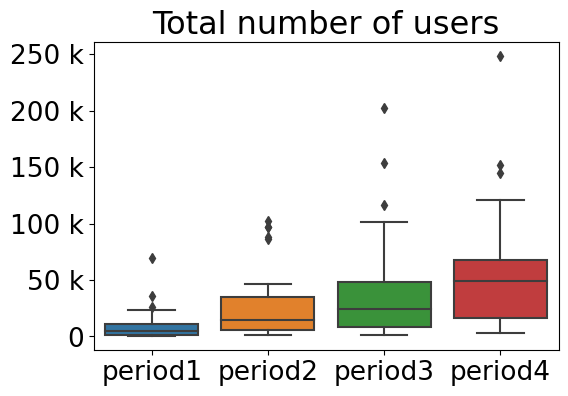

In [209]:
fig, axes = plt.subplots(1,1, figsize = [6, 4])

sns.boxplot(data = info_df["tot_users"].unstack())
axes.set_xticks(np.arange(0,4))
axes.set_xticklabels(periods, fontsize = xticks_fsize)
axes.yaxis.set_major_formatter(EngFormatter())
axes.set_xlabel("")
axes.set_ylabel("")
plt.yticks(fontsize = yticks_fsize)
axes.set_title("Total number of users", fontsize = title_fsize)

## Novax communities per period

<ipython-input-208-4b2c97fe58ae>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


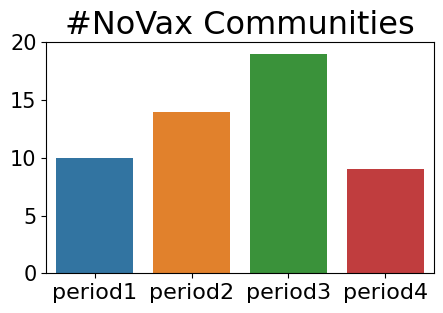

In [208]:
fig, axes = plt.subplots(1,1, figsize = [5, 3])

D = (~info_df["tot_novax"].isna()).unstack().sum().reset_index().rename(columns = {0: "novax_coms"})
sns.barplot(data = D, x = "period", y = "novax_coms")

axes.set_title("#NoVax Communities", fontsize = title_fsize)
axes.set_xlabel("")
axes.set_ylabel("")
axes.set_yticks(np.arange(0,21,5))
plt.xticks(fontsize = xticks_fsize - 3)
plt.yticks(fontsize = yticks_fsize - 4)

fig.show()


Periods 2 and 3 have the highest numbers of novax communities.

## Users per side

In [193]:
#i define with mpatches a red patch with label "No-Vax" for the legend
novax_patch = mpatches.Patch(color = "darkred", label = "No-Vax")
provax_patch = mpatches.Patch(color = "navy", label = "Other")

sns.set_palette(["darkred", "navy"])

leg_fsize = 20

<ipython-input-199-e5ba496cf1b9>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


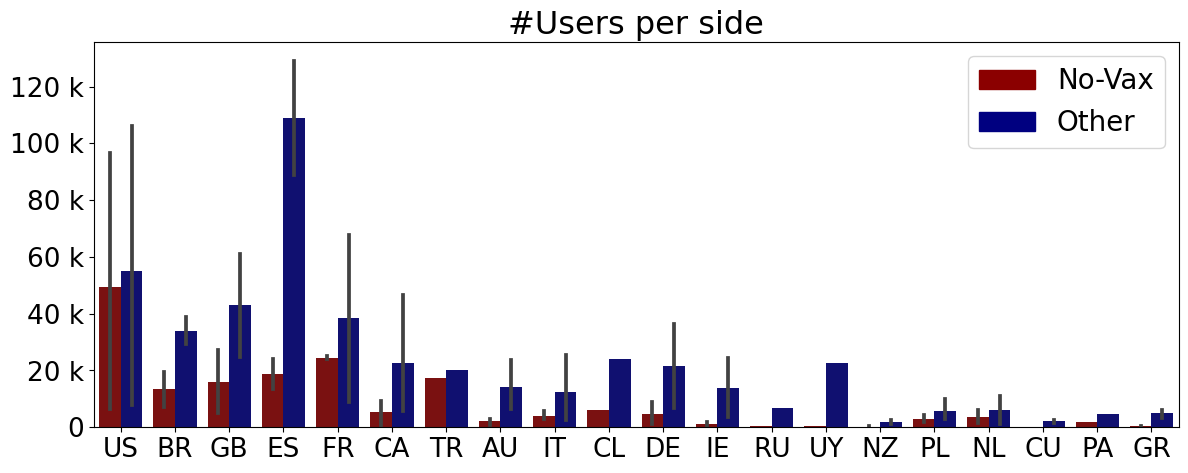

In [199]:
fig, axes = plt.subplots(1,1, figsize = [14, 5])

D = info_df[["tot_novax", "tot_provax"]].stack().reset_index().rename(columns = {"level_2": "Side", 0: "users"})

sns.barplot(data = D, x = "country", y = "users", hue = "Side")
axes.yaxis.set_major_formatter(EngFormatter())
plt.xticks(fontsize = xticks_fsize)
plt.yticks(fontsize = yticks_fsize)

axes.set_xlabel("")
axes.set_ylabel("")

plt.legend(handles = [novax_patch, provax_patch], fontsize = leg_fsize, loc = "upper right")

axes.set_title("#Users per side", fontsize = title_fsize)
fig.show()

In [200]:
sns.reset_defaults()

## NMI

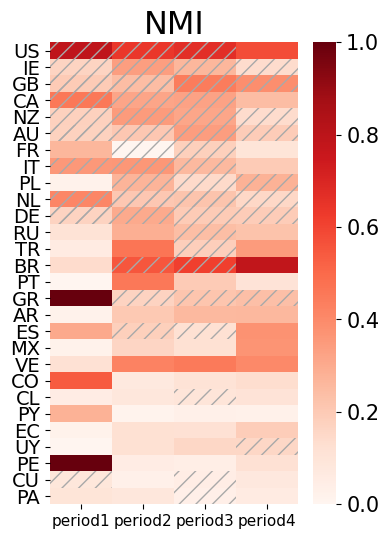

In [205]:
fig, axes = plt.subplots(1,1, figsize = [4, 6])

D = info_df["nmi_RTCO"].unstack().loc[lang_sort]
sns.heatmap(data = D, cmap = "Reds")
axes.set_xticklabels(periods, fontsize = 11)
axes.set_xlabel("")
axes.set_ylabel("")
plt.yticks(fontsize = 14, rotation = 0)
axes.set_title("NMI", fontsize = title_fsize)

cbar = axes.collections[0].colorbar
cbar.ax.tick_params(labelsize = cbar_fsize) 

#I create a dashed transparent patch as before correspinding to the network with a novax community
for _, (__, country, per, _) in novax_com.iterrows():
    row = [i for i, x in enumerate(D.index == country) if x][0]
    col = periods.index("period" + per)
    axes.add_patch(Rectangle((col, row), 1, 1, hatch = "//",
                           edgecolor = "darkgrey", fill = False, lw = 0.))


In [73]:
info_df["nmi_RTCO"].unstack().mean()

period
period1    0.251321
period2    0.240139
period3    0.229073
period4    0.235356
dtype: float64

The Normalized Mutual Information (that is the similarity between the partitions obtained in the hierarchical clustering on RT and CO networks, a measure of the Echo Chambers Effect) does not change over time.

But it sees to be darker in the top rows (English speaking countries), and lower in bottom rows (Spanish speaking countries). 

In [94]:
print("Average NMI", round(info_df["nmi_RTCO"].mean(), 3))
print("Average NMI English speaking countries", round(info_df.loc[en_countries, "nmi_RTCO"].mean(), 3))
print("Average NMI Spanish speaking countries", round(info_df.loc[es_countries, "nmi_RTCO"].mean(), 3))


Average NMI 0.239
Average NMI English speaking countries 0.338
Average NMI Spanish speaking countries 0.166


#### Is NMI stronger in English speaking countries?

In [98]:
ttest_ind(info_df.query("country in @en_countries")["nmi_RTCO"], info_df.query("country not in @en_countries")["nmi_RTCO"])

Ttest_indResult(statistic=2.85847189786576, pvalue=0.005093042843525993)

p < 0.0001 

Yes

#### Is NMI lower in Spanish speaking countries?

In [99]:
ttest_ind(info_df.query("country in @es_countries")["nmi_RTCO"], info_df.query("country not in @es_countries")["nmi_RTCO"])

Ttest_indResult(statistic=-3.5556106593969163, pvalue=0.0005573278565078506)

p < 0.0001

Yes

#### Is NMI stronger in networks with a novax community?

In [147]:
print("Average NMI network with a novax community", round(info_df["nmi_RTCO"].unstack().mask(novax_condition).stack().mean(), 3))
print("Average NMI network without a novax community", round(info_df["nmi_RTCO"].unstack().mask(~novax_condition).stack().mean(), 3))

Average NMI network with a novax community 0.268
Average NMI network without a novax community 0.214


In [148]:
ttest_ind(info_df["nmi_RTCO"].unstack().mask(novax_condition).stack(), 
          info_df["nmi_RTCO"].unstack().mask(~novax_condition).stack())

Ttest_indResult(statistic=1.4626506094394927, pvalue=0.14641435962724744)

Not statistically significant.

## Proportion Antivax Labels
Let us investigate the proportion of antivax labels obtained at the 1st round of labeling.

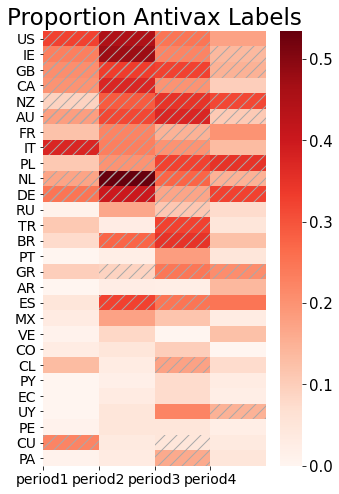

In [150]:
fig, axes = plt.subplots(1,1, figsize = [5, 8])

D = info_df["prop_antivax_labels"].unstack().loc[lang_sort]
sns.heatmap(data = D, cmap = "Reds")
axes.set_xticks(np.arange(0,4))
axes.set_xticklabels(periods, fontsize = 14)
axes.set_xlabel("")
axes.set_ylabel("")
plt.yticks(fontsize = 14, rotation = 0)
axes.set_title("Proportion Antivax Labels", fontsize = title_fsize)

cbar = axes.collections[0].colorbar
cbar.ax.tick_params(labelsize = cbar_fsize) 

#I create a dashed transparent patch as before correspinding to the network with a novax community
for _, (__, country, per, _) in novax_com.iterrows():
    row = [i for i, x in enumerate(D.index == country) if x][0]
    col = periods.index("period" + per)
    axes.add_patch(Rectangle((col, row), 1, 1, hatch = "//",
                           edgecolor = "darkgrey", fill = False, lw = 0.))


In [154]:
print("Average Proportion Antivax Labels network with a novax community", round(info_df["prop_antivax_labels"].unstack().mask(novax_condition).stack().mean(), 3))
print("Average Proportion Antivax Labels network without a novax community", round(info_df["prop_antivax_labels"].unstack().mask(~novax_condition).stack().mean(), 3))

Average Proportion Antivax Labels network with a novax community 0.254
Average Proportion Antivax Labels network without a novax community 0.069


Novax labels are strongly clustered, there are not networks with many antivax labels and not a novax community, that are networks with novax labels distributed in all the communities.

## Comparison Novax vs Other

In [246]:
pd.DataFrame({"novax": info_df.rename(columns = {"tot_novax": "Users", "novax_activity": "Retweets", "novax_density": "Density",
                         "novax_urls": "Urls", "novax_youtube": "YouTube", "novax_LC_prop": "Low-credible_prop",
                         "susp_novax": "Suspended_Accounts", "notfound_novax": "NotFound_Accounts"}) \
              [["Users", "Retweets", "Density", "Urls", "YouTube", "Low-credible_prop", 
                "Suspended_Accounts", "NotFound_Accounts"]].mean(),
    "other": info_df.rename(columns = {"tot_provax": "Users", "provax_activity": "Retweets", "provax_density": "Density",
                         "provax_urls": "Urls", "provax_youtube": "YouTube", "provax_LC_prop": "Low-credible_prop",
                         "susp_provax": "Suspended_Accounts", "notfound_provax": "NotFound_Accounts"}) \
              [["Users", "Retweets", "Density", "Urls", "YouTube", "Low-credible_prop", 
                "Suspended_Accounts", "NotFound_Accounts"]].mean()})

,novax,other
Users,8412.711538,22132.923077
Retweets,8.081526,4.699849
Density,0.003322,0.000381
Urls,3.631013,1.658618
YouTube,0.250399,0.021342
Low-credible_prop,0.175071,0.016488
Suspended_Accounts,0.133359,0.018204
NotFound_Accounts,0.255437,0.096353


Users in NoVax community seem to retweet more, be more densely connected, share more URLs and Youtube videos, share more low-credible domains, be more likely to be suspended and unexisting.

## Activity NoVax/Other
Compare the average number retweets, urls, youtube, LC domains shared by user in no-vax community and in rest of the networks.

We want to show that users in no-vax communities are more active than users in the same networks not in no-vax communities.

#### Average Retweets per user

In [5]:
print("Average Retweets of a novax user:", round(info_df.query("country not in @filtered_countries")["novax_activity"].mean(), 2))
print("Average Retweets of a provax user:", round(info_df.query("country not in @filtered_countries")["provax_activity"].mean(), 2))

Average Retweets of a novax user: 6.91
Average Retweets of a provax user: 4.28


Do users in no-vax communities share significantly more retweets?

In [6]:
ttest_ind(info_df["novax_activity"].dropna(), info_df["provax_activity"].dropna())

Ttest_indResult(statistic=3.491048464327829, pvalue=0.0007123271762243807)

p < 0.05

Users in no-vax community share significantly more retweets.

#### Average URL and YouTube per user

In [8]:
print("Average URLs shared by a novax user:", round(info_df["novax_urls"].mean(), 2))
print("Average URLs shared by a provax user:", round(info_df["provax_urls"].mean(), 2))
print("")
print("Average YouTube URLs shared by a novax user:", round(info_df["novax_youtube"].mean(), 4))
print("Average YouTube URLs shared by a provax user:", round(info_df["provax_youtube"].mean(), 4))

Average URLs shared by a novax user: 3.63
Average URLs shared by a provax user: 1.66

Average YouTube URLs shared by a novax user: 0.2504
Average YouTube URLs shared by a provax user: 0.0213


In [9]:
ttest_ind(info_df["novax_urls"].dropna(), info_df["provax_urls"].dropna())

Ttest_indResult(statistic=4.74426854086801, pvalue=6.828169682647264e-06)

In [10]:
ttest_ind(info_df["novax_youtube"].dropna(), info_df["provax_youtube"].dropna())

Ttest_indResult(statistic=9.872411171430672, pvalue=1.5605575753985928e-16)

Users in no-vax communities share significantly more URLs and more YouTube videos than users in the rest of the networks.

#### Average proportion of low-credible domains
We have a list of low-credible domains in English, French, Italian and Greek.

So, we filter the countries speaking one of this languages, and we analyse the proportion of links shared coming from one of these domains. 
To compute this proportion, we excluded all the neutral domains (urls pointing to social networks, urls shorteners...).

In [11]:
LC_countries = ["US", "GB", "CA", "IE", "AU", "NZ", "IT", "FR", "GR"]
print("Average LC domains in novax community:", str(round(info_df["novax_LC_prop"].dropna().loc[LC_countries].mean() * 100, 1)) + "%")
print("Average LC domains in provax community:", str(round(info_df["provax_LC_prop"].dropna().loc[LC_countries].mean() * 100, 1)) + "%")

Average LC domains in novax community: 26.0%
Average LC domains in provax community: 2.4%


In [12]:
ttest_ind(info_df["novax_LC_prop"].dropna().loc[LC_countries].dropna(), info_df["provax_LC_prop"].dropna().loc[LC_countries].dropna())

Ttest_indResult(statistic=14.343761854133716, pvalue=1.441968635695734e-20)

Users in no-vax communities share significantly more LC domains than the rest of the networks.

In [212]:
#normalization to transform the variables in log scale, centered in 1, 

class MidpointLogNorm(SymLogNorm):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))

    All arguments are the same as SymLogNorm, except for midpoint    
    """
    def __init__(self, lin_thres = 10**-10, lin_scale = 10**-11, midpoint = None, vmin = None, vmax = None):
        self.midpoint = midpoint
        self.lin_thres = lin_thres
        self.lin_scale = lin_scale
        #fraction of the cmap that the linear component occupies
        self.linear_proportion = (lin_scale / (lin_scale + 1)) * 0.5
        #print(self.linear_proportion)

        SymLogNorm.__init__(self, lin_thres, lin_scale, vmin, vmax)

    def __get_value__(self, v, log_val, clip=None):
        if v < -self.lin_thres or v > self.lin_thres:
            return log_val
        
        x = [-self.lin_thres, self.midpoint, self.lin_thres]
        y = [0.5 - self.linear_proportion, 0.5, 0.5 + self.linear_proportion]
        interpol = np.interp(v, x, y)
        return interpol

    def __call__(self, value, clip=None):
        log_val = SymLogNorm.__call__(self, value)

        out = [0] * len(value)
        for i, v in enumerate(value):
            out[i] = self.__get_value__(v, log_val[i])

        return np.ma.masked_array(out)

<ipython-input-215-9b6e7b36779c>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-215-9b6e7b36779c>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


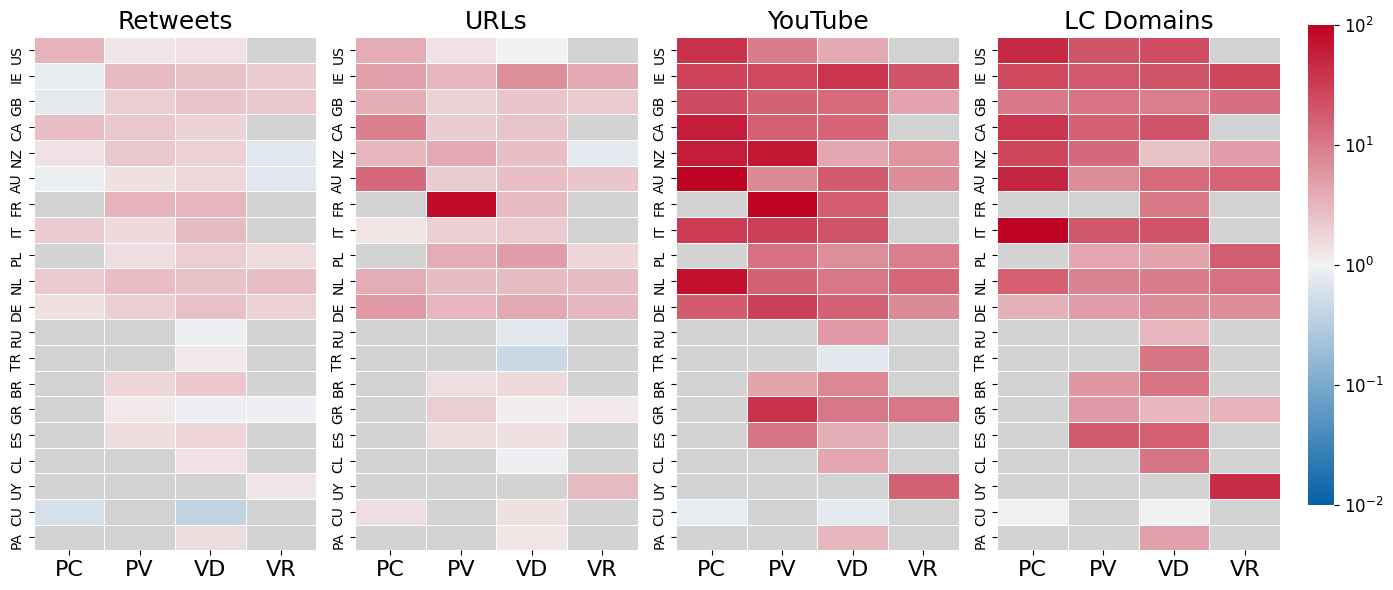

In [215]:
xlab_fsize = 16
cbar_fsize = 12
xticks_fsize = 16

df = info_df[["activity_ratio", "urls_ratio", "youtube_ratio", "LC_prop_ratio"]].unstack().dropna(how = "all")
df = df.loc[[u for u in lang_sort if u in df.index]].fillna(-1)
rdgn = sns.diverging_palette(h_neg = 250, h_pos = 10, s = 99, l = 40, 
                             as_cmap = True, center = "light")
lag_ratio_rb = MidpointLogNorm(midpoint = 10, vmin = 10**-2, vmax = 10**2)


fig, axes = plt.subplots(1,4, figsize = (13, 6))
cbar_ax = fig.add_axes([1.01, 0.15, .02, 0.8])

for ax, var, title in zip(axes.ravel(), ["activity_ratio", "urls_ratio", "youtube_ratio", "LC_prop_ratio"],
                  ["Retweets", "URLs", "YouTube", "LC Domains"]):
    sns.heatmap(df[var], cmap = rdgn, norm = lag_ratio_rb,
                #matplotlib.colors.LogNorm(),
                linewidths = 0.5, cbar = var == "LC_prop_ratio", ax = ax, cbar_ax = cbar_ax)
    sns.heatmap(df[var], mask = df[var] > -1,#((df != 0)&(~df.isna())&(~np.isinf(df))),
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)
    
    ax.set_title(title, fontsize = 18)
    ax.set_ylabel("", fontsize = 18)
    ax.set_xlabel("", fontsize = 18)
    #cbar = ax.collections[0].colorbar
    #set ticks on colorbar with % format
    #cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    #cbar.ax.set_ylim([max(D.min().min(), 0), D.max().max()])

    ax.set_xticklabels(["PC", "PV", "VD", "VR"], fontsize = xticks_fsize)
    

    if var == "LC_prop_ratio":
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = cbar_fsize) 

plt.tight_layout()

fig.show()

## RWC

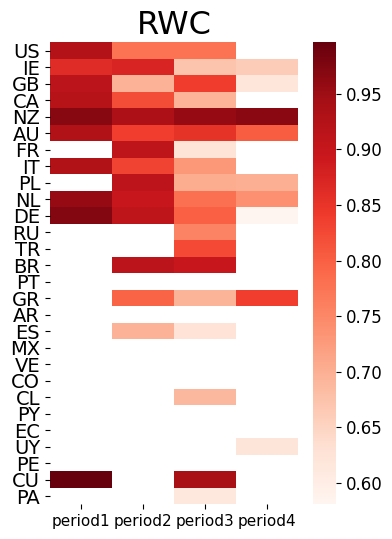

In [217]:
fig, axes = plt.subplots(1,1, figsize = [4, 6])

D = info_df["rwc_novax"].unstack().loc[lang_sort]
sns.heatmap(data = D, cmap = "Reds")
axes.set_xticklabels(periods, fontsize = 11)
axes.set_xlabel("")
axes.set_ylabel("")
plt.yticks(fontsize = 14, rotation = 0)
axes.set_title("RWC", fontsize = title_fsize)

cbar = axes.collections[0].colorbar
cbar.ax.tick_params(labelsize = cbar_fsize) 



In [219]:
info_df["rwc_novax"].unstack().mean()

period
period1    0.936926
period2    0.843284
period3    0.761870
period4    0.725582
dtype: float64

Is RWC decreasing?

In [250]:
print("Is RWC significantly decreasing from period 1 to period 2?")
print("")
print(ttest_ind(info_df["rwc_novax"].unstack()["period1"].dropna(), info_df["rwc_novax"].unstack()["period2"].dropna()))
print("p < 0.01")
print("Yes")

Is RWC significantly decreasing from period 1 to period 2?

Ttest_indResult(statistic=3.4562691405614037, pvalue=0.0022477351462251165)
p < 0.01
Yes


In [251]:
print("Is RWC significantly decreasing from period 2 to period 3?")
print("")
print(ttest_ind(info_df["rwc_novax"].unstack()["period2"].dropna(), info_df["rwc_novax"].unstack()["period3"].dropna()))
print("p < 0.05")
print("Yes")

Is RWC significantly decreasing from period 2 to period 3?

Ttest_indResult(statistic=2.4606634646635785, pvalue=0.019639755695782923)
p < 0.05
Yes


In [252]:
print("Is RWC significantly decreasing from period 3 to period 4?")
print("")
print(ttest_ind(info_df["rwc_novax"].unstack()["period3"].dropna(), info_df["rwc_novax"].unstack()["period4"].dropna()))
print("No")

Is RWC significantly decreasing from period 3 to period 4?

Ttest_indResult(statistic=0.8127331666923192, pvalue=0.4237508882202874)
No


The polarization is decreasing from pre-COVID to COVID period, and from pre-vaccine to vaccine development.